In [6]:
!git clone https://github.com/anupamhap/mb.git

Cloning into 'mb'...
remote: Counting objects: 354, done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 354 (delta 4), reused 26 (delta 3), pack-reused 324
Receiving objects: 100% (354/354), 60.61 MiB | 53.09 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [4]:
!pwd

/content


In [5]:
!ls

datalab


In [0]:
import os
os.chdir("mb/Tree_Root_Detection")

In [2]:
!ls

datalab  mb


In [0]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging
import glob

In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn

Using TensorFlow backend.


In [34]:
!git pull

remote: Counting objects: 7, done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/anupamhap/mb
   640f78f..fffc420  master     -> origin/master
Updating 640f78f..fffc420
Fast-forward
 .../data/{non_tree => non}/Selection_126.jpg            | Bin
 .../data/{non_tree => non}/Selection_127.jpg            | Bin
 Tree_Root_Detection/data/non_tree/16.JPG                | Bin 12154 -> 0 bytes
 Tree_Root_Detection/data/non_tree/17.JPG                | Bin 14571 -> 0 bytes
 Tree_Root_Detection/data/non_tree/18.JPG                | Bin 12480 -> 0 bytes
 Tree_Root_Detection/data/non_tree/19.JPG                | Bin 15856 -> 0 bytes
 .../test_images/{Selection_114.jpg => text.jpg}         | Bin
 7 files changed, 0 insertions(+), 0 deletions(-)
 rename Tree_Root_Detection/data/{non_tree => non}/Selection_126.jpg (100%)
 rename Tree_Root_Detection/data/{non_tree => non}/Selection

In [0]:
width = 58
height = 58

#images = []

In [11]:
roots   = glob.glob('data/tree/*.JPG') 
roots += glob.glob('data/tree/*.jpg')
non_roots   = glob.glob('data/non_tree/*.JPG')
non_roots   += glob.glob('data/non_tree/*.jpg')
print(len(roots), len(non_roots))

59 60


In [0]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (7,7), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst



In [13]:


def create_data(n=10):
   for i in range(len(roots)):
       img=mpimg.imread(roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(1)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(1)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(5)

NameError: ignored

In [107]:
def create_data(n=10):
   for i in range(len(non_roots)):
       img=mpimg.imread(non_roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(0)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(0)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(5)

Total number of images in the augmented dataset =  537


In [18]:
print(len(roots))

59


In [30]:
X_train_aug_roots = []
y_train_aug = []
for i in range(len(roots)):
     img=mpimg.imread(roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(1)
     img = cv2.flip(img,1)
     X_train_aug_roots.append(img)
     y_train_aug.append(1)
     img = rotate_img(img)
     X_train_aug_roots.append(img)
     y_train_aug.append(1)
#      img=random_warp(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(1)
#      img=random_brightness(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(1)
    


for i in range(len(non_roots)):
     img=mpimg.imread(non_roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
     img = cv2.flip(img,1)
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
     img = rotate_img(img)
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
#      img=random_warp(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(0)
#      img=random_brightness(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(0)
     

   
print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))  
print(len(y_train_aug))

Total number of images in the augmented dataset =  357
357


In [0]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.5))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.4))
    #seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.2))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [0]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence

images, labels = shuffle(X_train_aug_roots, y_train_aug)

AttributeError: ignored

In [65]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype, images.shape)
print(type(images))
print(labels)

uint8 (357, 58, 58, 3)
<class 'numpy.ndarray'>
[1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0
 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1
 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1
 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1
 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1
 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0
 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1]


In [66]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_28 (Dropout)         (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_29 (Dropout)         (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 2, 2, 64)          27712     
__________

In [67]:
keras_model.fit(images, labels, epochs=100, batch_size=32, verbose=1, shuffle=True, validation_split=0.15)

Train on 303 samples, validate on 54 samples
Epoch 1/100
303/303 [==============================] - 3s 9ms/step - loss: 0.7450 - acc: 0.4389 - val_loss: 0.6815 - val_acc: 0.5556
Epoch 2/100
303/303 [==============================] - 1s 4ms/step - loss: 0.6963 - acc: 0.4719 - val_loss: 0.6955 - val_acc: 0.4259
Epoch 3/100
303/303 [==============================] - 1s 4ms/step - loss: 0.6999 - acc: 0.4554 - val_loss: 0.6920 - val_acc: 0.5556
Epoch 4/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6813 - acc: 0.5413 - val_loss: 0.6886 - val_acc: 0.5370
Epoch 5/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6919 - acc: 0.5545 - val_loss: 0.6935 - val_acc: 0.5741
Epoch 6/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6833 - acc: 0.5974 - val_loss: 0.6917 - val_acc: 0.5926
Epoch 7/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6857 - acc: 0.5776 - val_loss: 0.6848 - val_acc: 0.6852
Epoch 8/100
303/303 [===

303/303 [==============================] - 1s 3ms/step - loss: 0.6160 - acc: 0.7096 - val_loss: 0.5028 - val_acc: 0.7963
Epoch 13/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6387 - acc: 0.7261 - val_loss: 0.5454 - val_acc: 0.8148
Epoch 14/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6042 - acc: 0.7327 - val_loss: 0.5792 - val_acc: 0.7222
Epoch 15/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6080 - acc: 0.7096 - val_loss: 0.5915 - val_acc: 0.6481
Epoch 16/100
303/303 [==============================] - 1s 3ms/step - loss: 0.5833 - acc: 0.7228 - val_loss: 0.4689 - val_acc: 0.8704
Epoch 17/100
303/303 [==============================] - 1s 3ms/step - loss: 0.5934 - acc: 0.6997 - val_loss: 0.5789 - val_acc: 0.6481
Epoch 18/100
303/303 [==============================] - 1s 3ms/step - loss: 0.6216 - acc: 0.7393 - val_loss: 0.4956 - val_acc: 0.7222
Epoch 19/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.5499 - acc: 0.7591 - val_loss: 0.4951 - val_acc: 0.7778
Epoch 24/100
303/303 [==============================] - 1s 3ms/step - loss: 0.5252 - acc: 0.7591 - val_loss: 0.5385 - val_acc: 0.7593
Epoch 25/100
303/303 [==============================] - 1s 3ms/step - loss: 0.5184 - acc: 0.7492 - val_loss: 0.3797 - val_acc: 0.8333
Epoch 26/100
303/303 [==============================] - 1s 3ms/step - loss: 0.5248 - acc: 0.7624 - val_loss: 0.4374 - val_acc: 0.8519
Epoch 27/100
303/303 [==============================] - 1s 3ms/step - loss: 0.5184 - acc: 0.7426 - val_loss: 0.4040 - val_acc: 0.8519
Epoch 28/100
303/303 [==============================] - 1s 3ms/step - loss: 0.5031 - acc: 0.7459 - val_loss: 0.3974 - val_acc: 0.8148
Epoch 29/100
303/303 [==============================] - 1s 3ms/step - loss: 0.4805 - acc: 0.7888 - val_loss: 0.3837 - val_acc: 0.8148
Epoch 30/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.4082 - acc: 0.8383 - val_loss: 0.2973 - val_acc: 0.8889
Epoch 35/100
303/303 [==============================] - 1s 3ms/step - loss: 0.4651 - acc: 0.8482 - val_loss: 0.3830 - val_acc: 0.8148
Epoch 36/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3733 - acc: 0.8515 - val_loss: 0.2391 - val_acc: 0.9259
Epoch 37/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3772 - acc: 0.8581 - val_loss: 0.2288 - val_acc: 0.9444
Epoch 38/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3799 - acc: 0.8647 - val_loss: 0.3624 - val_acc: 0.8333
Epoch 39/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3860 - acc: 0.8482 - val_loss: 0.3762 - val_acc: 0.8704
Epoch 40/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3832 - acc: 0.8284 - val_loss: 0.2885 - val_acc: 0.8704
Epoch 41/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.3022 - acc: 0.8878 - val_loss: 0.1437 - val_acc: 0.9815
Epoch 46/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2890 - acc: 0.9076 - val_loss: 0.1872 - val_acc: 0.9444
Epoch 47/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2707 - acc: 0.8878 - val_loss: 0.2437 - val_acc: 0.9444
Epoch 48/100
303/303 [==============================] - 1s 4ms/step - loss: 0.2704 - acc: 0.9043 - val_loss: 0.1317 - val_acc: 0.9630
Epoch 49/100
303/303 [==============================] - 1s 4ms/step - loss: 0.2494 - acc: 0.9010 - val_loss: 0.1694 - val_acc: 0.9630
Epoch 50/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3026 - acc: 0.8911 - val_loss: 0.3966 - val_acc: 0.8889
Epoch 51/100
303/303 [==============================] - 1s 4ms/step - loss: 0.2768 - acc: 0.8911 - val_loss: 0.2562 - val_acc: 0.9074
Epoch 52/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.2094 - acc: 0.9307 - val_loss: 0.1034 - val_acc: 0.9815
Epoch 57/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3189 - acc: 0.8977 - val_loss: 0.3342 - val_acc: 0.8889
Epoch 58/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3142 - acc: 0.8746 - val_loss: 0.2464 - val_acc: 0.9074
Epoch 59/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1720 - acc: 0.9538 - val_loss: 0.0975 - val_acc: 1.0000
Epoch 60/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2155 - acc: 0.9406 - val_loss: 0.1098 - val_acc: 0.9815
Epoch 61/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2514 - acc: 0.9142 - val_loss: 0.1126 - val_acc: 0.9815
Epoch 62/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1877 - acc: 0.9439 - val_loss: 0.0951 - val_acc: 0.9815
Epoch 63/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.3083 - acc: 0.8944 - val_loss: 0.2618 - val_acc: 0.9074
Epoch 68/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2048 - acc: 0.9274 - val_loss: 0.3027 - val_acc: 0.8333
Epoch 69/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2878 - acc: 0.9043 - val_loss: 0.4181 - val_acc: 0.8333
Epoch 70/100
303/303 [==============================] - 1s 3ms/step - loss: 0.3200 - acc: 0.8779 - val_loss: 0.2379 - val_acc: 0.9074
Epoch 71/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2431 - acc: 0.9109 - val_loss: 0.1076 - val_acc: 0.9815
Epoch 72/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2123 - acc: 0.9208 - val_loss: 0.1161 - val_acc: 0.9815
Epoch 73/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2012 - acc: 0.9274 - val_loss: 0.1107 - val_acc: 0.9815
Epoch 74/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.1750 - acc: 0.9406 - val_loss: 0.1339 - val_acc: 0.9444
Epoch 79/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1860 - acc: 0.9406 - val_loss: 0.2546 - val_acc: 0.9074
Epoch 80/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2216 - acc: 0.9208 - val_loss: 0.3963 - val_acc: 0.8519
Epoch 81/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2587 - acc: 0.9010 - val_loss: 0.3661 - val_acc: 0.8519
Epoch 82/100
303/303 [==============================] - 1s 3ms/step - loss: 0.2242 - acc: 0.9076 - val_loss: 0.2701 - val_acc: 0.8889
Epoch 83/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1940 - acc: 0.9208 - val_loss: 0.1447 - val_acc: 0.9444
Epoch 84/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1782 - acc: 0.9340 - val_loss: 0.3412 - val_acc: 0.8333
Epoch 85/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.1360 - acc: 0.9604 - val_loss: 0.1457 - val_acc: 0.9444
Epoch 90/100
303/303 [==============================] - 1s 3ms/step - loss: 0.0817 - acc: 0.9703 - val_loss: 0.0891 - val_acc: 0.9815
Epoch 91/100
303/303 [==============================] - 1s 3ms/step - loss: 0.0853 - acc: 0.9736 - val_loss: 0.0888 - val_acc: 0.9630
Epoch 92/100
303/303 [==============================] - 1s 3ms/step - loss: 0.0662 - acc: 0.9769 - val_loss: 0.0610 - val_acc: 0.9815
Epoch 93/100
303/303 [==============================] - 1s 3ms/step - loss: 0.0734 - acc: 0.9736 - val_loss: 0.0619 - val_acc: 0.9815
Epoch 94/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1154 - acc: 0.9505 - val_loss: 0.0644 - val_acc: 0.9815
Epoch 95/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1125 - acc: 0.9571 - val_loss: 0.1171 - val_acc: 0.9444
Epoch 96/100
303/303 [==============================] - 1s 3ms/step - loss:

303/303 [==============================] - 1s 3ms/step - loss: 0.0853 - acc: 0.9604 - val_loss: 0.0732 - val_acc: 0.9815


In [0]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [0]:
save_keras_model(keras_model, 'keras')

In [0]:
!ls

# New Section

In [0]:
from google.colab import files


files.download('kerasmodel.h5')
files.download('kerasmodel.json')


In [0]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [0]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    print(nxsteps)
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (58,58))
#             plt.imshow(subimg)
#             plt.show
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(subimg, 0))[0, 0])
#             print(test_prediction)
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [0]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

In [0]:
# Convert hog image to RGB
def hot_to_rgb(data):
    data_ = (data - np.min(data)) / (np.max(data) - np.min(data))
    my_cmap = plt.cm.get_cmap('hot')
    color_array = my_cmap(data_)
    final_array = (np.dstack((color_array[:,:,0],color_array[:,:,1],color_array[:,:,2]))*255).astype(np.uint8)    
    return final_array

['test_images/treeroot.JPG']
test_images/treeroot.JPG
13


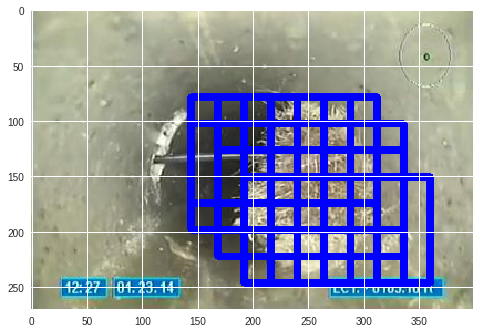

In [45]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 270
scale = 1.5
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('test_images/treeroot.JPG')
print(test_images)
for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    #print(boxes[0][0])
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

In [0]:
os.chdir("test_images")


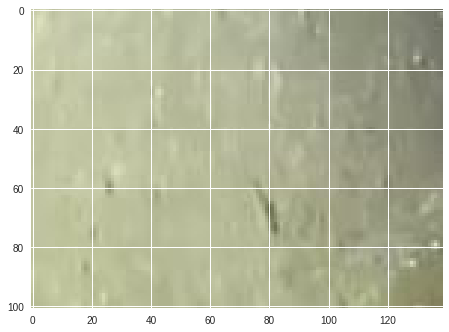

In [46]:
plt.imshow(mpimg.imread( "data/non_tree/1.JPG"))

In [47]:
im = mpimg.imread( "data/non_tree/1.JPG")
im = cv2.resize(im,(58,58))
print( round(inf_model.predict(np.expand_dims(im, 0))[0, 0]))

0.0


In [41]:
!ls

classifiers		       __pycache__
data			       Selection_107.jpg
fault1.mp4		       Selection_108.jpg
fault7.mp4		       Selection_109.jpg
Hello,_Colaboratory (1).ipynb  Selection_110.jpg
Hello,_Colaboratory (2).ipynb  test_image2.png
helper.py		       test_images
kerasmodel.h5		       tree_root_intrusion_detection.ipynb
kerasmodel.json		       videos


In [0]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [0]:
#print(scales,ystarts)
from collections import deque

# ystart = 30
# ystop = 270
# scale = 1.5


ystart = 250
ystop = 720
scale = 1.5

heat_history=deque(maxlen=8)
def process_frame(image):
    boxes=[]
#     for i in range(len(scales)):
    boxes.append(find_roots(image, ystart, ystop, scale, pix_per_cell,cell_per_block )) #find_roots(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
#     heat_history.append(heatmap_img)
#     heatmap_img = np.array(heat_history).sum(axis=0)
    heatmap_img = apply_threshold(heatmap_img,2)
    
    # # Find final boxes from heatmap using label function
    labels = label(heatmap_img)
    heatmap_img = hot_to_rgb(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img[0:150,0:150,:] = cv2.resize(heatmap_img,(150,150))
#     draw_img = draw_boxes(image,boxes)
    
    return draw_img


In [51]:
!pip install moviepy

    100% |████████████████████████████████| 378kB 5.0MB/s 
    100% |████████████████████████████████| 3.3MB 5.3MB/s 
    100% |████████████████████████████████| 51kB 14.9MB/s 
  Running setup.py bdist_wheel for moviepy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ad/92/4d/a6c6307d4c2219d002646bd4a5987e31fd5697f6ea7778b2c0
Successfully built moviepy


In [0]:
from moviepy.editor import VideoFileClip

output_location = 'fault7_output_try.mp4'
# output_location = 'fault1_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("fault7.mp4").subclip(0,10)

video_output = video_input.fl_image(process_frame) #NOTE: this function expects color images!!

#%time undist_clip.write_videofile(undist_output, audio=False)
# print("anupam")
video_output.write_videofile(output_location, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()
video_output.reader.close()
video_output.audio.reader.close_proc()

37
[MoviePy] >>>> Building video fault7_output_try.mp4
[MoviePy] Writing video fault7_output_try.mp4


  0%|          | 0/300 [00:00<?, ?it/s]

37


  0%|          | 1/300 [00:02<10:23,  2.08s/it]

37


  1%|          | 2/300 [00:04<10:07,  2.04s/it]

37


  1%|          | 3/300 [00:06<10:06,  2.04s/it]

37


  1%|▏         | 4/300 [00:08<10:02,  2.03s/it]

37


  2%|▏         | 5/300 [00:10<09:58,  2.03s/it]

37


  2%|▏         | 6/300 [00:12<09:54,  2.02s/it]

37


  2%|▏         | 7/300 [00:14<09:52,  2.02s/it]

37


  3%|▎         | 8/300 [00:16<09:49,  2.02s/it]

37


  3%|▎         | 9/300 [00:18<09:46,  2.01s/it]

37


  3%|▎         | 10/300 [00:20<09:46,  2.02s/it]

37


  4%|▎         | 11/300 [00:22<09:47,  2.03s/it]

37


  4%|▍         | 12/300 [00:24<09:47,  2.04s/it]

37


  4%|▍         | 13/300 [00:26<09:45,  2.04s/it]

37


  5%|▍         | 14/300 [00:28<09:44,  2.04s/it]

37


  5%|▌         | 15/300 [00:30<09:43,  2.05s/it]

37


  5%|▌         | 16/300 [00:32<09:42,  2.05s/it]

37


  6%|▌         | 17/300 [00:35<09:42,  2.06s/it]

37


  6%|▌         | 18/300 [00:37<09:44,  2.07s/it]

37


  6%|▋         | 19/300 [00:39<09:45,  2.09s/it]

37


  7%|▋         | 20/300 [00:41<09:44,  2.09s/it]

37


  7%|▋         | 21/300 [00:43<09:42,  2.09s/it]

37


  7%|▋         | 22/300 [00:45<09:40,  2.09s/it]

37


  8%|▊         | 23/300 [00:48<09:39,  2.09s/it]

37


  8%|▊         | 24/300 [00:50<09:37,  2.09s/it]

37


  8%|▊         | 25/300 [00:52<09:35,  2.09s/it]

37


  9%|▊         | 26/300 [00:54<09:33,  2.09s/it]

37


  9%|▉         | 27/300 [00:56<09:31,  2.09s/it]

37


  9%|▉         | 28/300 [00:58<09:28,  2.09s/it]

37


 10%|▉         | 29/300 [01:00<09:26,  2.09s/it]

37


 10%|█         | 30/300 [01:02<09:23,  2.09s/it]

37


 10%|█         | 31/300 [01:04<09:22,  2.09s/it]

37


 11%|█         | 32/300 [01:06<09:20,  2.09s/it]

37


 11%|█         | 33/300 [01:09<09:18,  2.09s/it]

37


 11%|█▏        | 34/300 [01:11<09:16,  2.09s/it]

37


 12%|█▏        | 35/300 [01:13<09:14,  2.09s/it]

37


 12%|█▏        | 36/300 [01:15<09:12,  2.09s/it]

37


 12%|█▏        | 37/300 [01:17<09:11,  2.10s/it]

37


 13%|█▎        | 38/300 [01:19<09:08,  2.09s/it]

37


 13%|█▎        | 39/300 [01:21<09:06,  2.09s/it]

37


 13%|█▎        | 40/300 [01:23<09:04,  2.10s/it]

37


 14%|█▎        | 41/300 [01:25<09:02,  2.10s/it]

37


 14%|█▍        | 42/300 [01:28<09:00,  2.10s/it]

37


 14%|█▍        | 43/300 [01:30<08:59,  2.10s/it]

37


 15%|█▍        | 44/300 [01:32<08:57,  2.10s/it]

37


 15%|█▌        | 45/300 [01:34<08:55,  2.10s/it]

37


 15%|█▌        | 46/300 [01:36<08:53,  2.10s/it]

37


 16%|█▌        | 47/300 [01:38<08:51,  2.10s/it]

37


 16%|█▌        | 48/300 [01:40<08:49,  2.10s/it]

37


 16%|█▋        | 49/300 [01:43<08:47,  2.10s/it]

37


 17%|█▋        | 50/300 [01:45<08:45,  2.10s/it]

37


 17%|█▋        | 51/300 [01:47<08:43,  2.10s/it]

37


 17%|█▋        | 52/300 [01:49<08:41,  2.10s/it]

37


 18%|█▊        | 53/300 [01:51<08:39,  2.10s/it]

37


 18%|█▊        | 54/300 [01:53<08:37,  2.10s/it]

37


 18%|█▊        | 55/300 [01:55<08:35,  2.10s/it]

37


 19%|█▊        | 56/300 [01:57<08:33,  2.10s/it]

37


 19%|█▉        | 57/300 [01:59<08:31,  2.10s/it]

37


 19%|█▉        | 58/300 [02:02<08:29,  2.11s/it]

37


 20%|█▉        | 59/300 [02:04<08:28,  2.11s/it]

37


 20%|██        | 60/300 [02:06<08:26,  2.11s/it]

37


 20%|██        | 61/300 [02:08<08:24,  2.11s/it]

37


 21%|██        | 62/300 [02:10<08:21,  2.11s/it]

37


 21%|██        | 63/300 [02:12<08:19,  2.11s/it]

37


 21%|██▏       | 64/300 [02:14<08:17,  2.11s/it]

37


 22%|██▏       | 65/300 [02:17<08:15,  2.11s/it]

37


 22%|██▏       | 66/300 [02:19<08:13,  2.11s/it]

37


 22%|██▏       | 67/300 [02:21<08:11,  2.11s/it]

37


 23%|██▎       | 68/300 [02:23<08:10,  2.11s/it]

37


 23%|██▎       | 69/300 [02:25<08:08,  2.11s/it]

37


 23%|██▎       | 70/300 [02:27<08:05,  2.11s/it]

37


 24%|██▎       | 71/300 [02:30<08:03,  2.11s/it]

37


 24%|██▍       | 72/300 [02:32<08:01,  2.11s/it]

37


 24%|██▍       | 73/300 [02:34<07:59,  2.11s/it]

37


 25%|██▍       | 74/300 [02:36<07:57,  2.11s/it]

37


 25%|██▌       | 75/300 [02:38<07:55,  2.11s/it]

37


 25%|██▌       | 76/300 [02:40<07:53,  2.11s/it]

37


 26%|██▌       | 77/300 [02:42<07:51,  2.11s/it]

37


 26%|██▌       | 78/300 [02:44<07:48,  2.11s/it]

37


 26%|██▋       | 79/300 [02:46<07:46,  2.11s/it]

37


 27%|██▋       | 80/300 [02:48<07:44,  2.11s/it]

37


 27%|██▋       | 81/300 [02:50<07:42,  2.11s/it]

37


 27%|██▋       | 82/300 [02:53<07:40,  2.11s/it]

37


 28%|██▊       | 83/300 [02:55<07:37,  2.11s/it]

37


 28%|██▊       | 84/300 [02:57<07:35,  2.11s/it]

37


 28%|██▊       | 85/300 [02:59<07:33,  2.11s/it]

37


 29%|██▊       | 86/300 [03:01<07:30,  2.11s/it]

37


 29%|██▉       | 87/300 [03:03<07:28,  2.11s/it]

37


 29%|██▉       | 88/300 [03:05<07:26,  2.11s/it]

37


 30%|██▉       | 89/300 [03:07<07:24,  2.11s/it]

37


 30%|███       | 90/300 [03:09<07:22,  2.11s/it]

37


 30%|███       | 91/300 [03:11<07:20,  2.11s/it]

37


 31%|███       | 92/300 [03:13<07:18,  2.11s/it]

37


 31%|███       | 93/300 [03:16<07:16,  2.11s/it]

37


 31%|███▏      | 94/300 [03:18<07:14,  2.11s/it]

37


 32%|███▏      | 95/300 [03:20<07:12,  2.11s/it]

37


 32%|███▏      | 96/300 [03:22<07:10,  2.11s/it]

37


 32%|███▏      | 97/300 [03:24<07:08,  2.11s/it]

37


 33%|███▎      | 98/300 [03:26<07:06,  2.11s/it]

37


 33%|███▎      | 99/300 [03:28<07:04,  2.11s/it]

37


 33%|███▎      | 100/300 [03:31<07:02,  2.11s/it]

37


 34%|███▎      | 101/300 [03:33<07:00,  2.11s/it]

37


 34%|███▍      | 102/300 [03:35<06:58,  2.11s/it]

37


 34%|███▍      | 103/300 [03:37<06:56,  2.11s/it]

37


 35%|███▍      | 104/300 [03:39<06:53,  2.11s/it]

37


 35%|███▌      | 105/300 [03:41<06:51,  2.11s/it]

37


 35%|███▌      | 106/300 [03:43<06:49,  2.11s/it]

37


 36%|███▌      | 107/300 [03:46<06:47,  2.11s/it]

37


 36%|███▌      | 108/300 [03:48<06:45,  2.11s/it]

37


 36%|███▋      | 109/300 [03:50<06:43,  2.11s/it]

37


 37%|███▋      | 110/300 [03:52<06:41,  2.11s/it]

37


 37%|███▋      | 111/300 [03:54<06:39,  2.11s/it]

37


 37%|███▋      | 112/300 [03:56<06:37,  2.11s/it]

37


 38%|███▊      | 113/300 [03:58<06:34,  2.11s/it]

37


 38%|███▊      | 114/300 [04:00<06:32,  2.11s/it]

37


 38%|███▊      | 115/300 [04:02<06:30,  2.11s/it]

37


 39%|███▊      | 116/300 [04:04<06:28,  2.11s/it]

37


 39%|███▉      | 117/300 [04:07<06:26,  2.11s/it]

37


 39%|███▉      | 118/300 [04:09<06:24,  2.11s/it]

37


 40%|███▉      | 119/300 [04:11<06:22,  2.11s/it]

37


 40%|████      | 120/300 [04:13<06:20,  2.11s/it]

37


 40%|████      | 121/300 [04:15<06:17,  2.11s/it]

37


 41%|████      | 122/300 [04:17<06:15,  2.11s/it]

37


 41%|████      | 123/300 [04:19<06:13,  2.11s/it]

37


 41%|████▏     | 124/300 [04:22<06:11,  2.11s/it]

37


 42%|████▏     | 125/300 [04:24<06:09,  2.11s/it]

37


 42%|████▏     | 126/300 [04:26<06:07,  2.11s/it]

37


 42%|████▏     | 127/300 [04:28<06:05,  2.11s/it]

37


 43%|████▎     | 128/300 [04:30<06:03,  2.11s/it]

37


 43%|████▎     | 129/300 [04:32<06:01,  2.11s/it]

37


 43%|████▎     | 130/300 [04:34<05:59,  2.11s/it]

37


 44%|████▎     | 131/300 [04:36<05:57,  2.11s/it]

37


 44%|████▍     | 132/300 [04:38<05:54,  2.11s/it]

37


 44%|████▍     | 133/300 [04:40<05:52,  2.11s/it]

37


 45%|████▍     | 134/300 [04:43<05:50,  2.11s/it]

37


 45%|████▌     | 135/300 [04:45<05:48,  2.11s/it]

37


 45%|████▌     | 136/300 [04:47<05:46,  2.11s/it]

37


 46%|████▌     | 137/300 [04:49<05:43,  2.11s/it]

37


 46%|████▌     | 138/300 [04:51<05:41,  2.11s/it]

37


 46%|████▋     | 139/300 [04:53<05:39,  2.11s/it]

37


 47%|████▋     | 140/300 [04:55<05:37,  2.11s/it]

37


 47%|████▋     | 141/300 [04:57<05:35,  2.11s/it]

37


 47%|████▋     | 142/300 [04:59<05:33,  2.11s/it]

37


 48%|████▊     | 143/300 [05:01<05:31,  2.11s/it]

37


 48%|████▊     | 144/300 [05:03<05:29,  2.11s/it]

37


 48%|████▊     | 145/300 [05:05<05:26,  2.11s/it]

37


 49%|████▊     | 146/300 [05:07<05:24,  2.11s/it]

37


 49%|████▉     | 147/300 [05:10<05:22,  2.11s/it]

37


 49%|████▉     | 148/300 [05:12<05:20,  2.11s/it]

37


 50%|████▉     | 149/300 [05:14<05:18,  2.11s/it]

37


 50%|█████     | 150/300 [05:16<05:16,  2.11s/it]

37


 50%|█████     | 151/300 [05:18<05:14,  2.11s/it]

37


 51%|█████     | 152/300 [05:21<05:12,  2.11s/it]

37


 51%|█████     | 153/300 [05:23<05:10,  2.11s/it]

37


 51%|█████▏    | 154/300 [05:25<05:08,  2.11s/it]

37


 52%|█████▏    | 155/300 [05:27<05:06,  2.12s/it]

37


 52%|█████▏    | 156/300 [05:29<05:04,  2.12s/it]

37


 52%|█████▏    | 157/300 [05:32<05:02,  2.12s/it]

37


 53%|█████▎    | 158/300 [05:34<05:00,  2.12s/it]

37


 53%|█████▎    | 159/300 [05:36<04:58,  2.12s/it]

37


 53%|█████▎    | 160/300 [05:38<04:56,  2.12s/it]

37


 54%|█████▎    | 161/300 [05:41<04:54,  2.12s/it]

37


 54%|█████▍    | 162/300 [05:43<04:52,  2.12s/it]

37


 54%|█████▍    | 163/300 [05:45<04:50,  2.12s/it]

37


 55%|█████▍    | 164/300 [05:47<04:48,  2.12s/it]

37


 55%|█████▌    | 165/300 [05:50<04:46,  2.12s/it]

37


In [0]:
                                                       ls

In [0]:
from google.colab import files

files.download('fault7_output_try.mp4')

# files.download('fault1_output.mp4')


In [0]:
os.chdir('..')

In [0]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))



In [0]:
!git commit -m "output video"

In [0]:
!git config --global user.email "anupamb266@gmail.com"
! git config --global user.name "anupamhap"

In [0]:
!git push

In [0]:
!ls

In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')

In [0]:
!git pull

In [0]:
!git reset